# Modeling Building V2

## Import libraries

In [1]:
''' importing basic data analysis packages'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os,random, math, psutil, pickle 
import missingno as msno
from datetime import timedelta 
import plotly.express as px
import itertools

'''For Stat'''
import statsmodels.api as sm
from scipy.stats import chi2_contingency


''' For ML'''
from sklearn import metrics, svm
from sklearn.linear_model  import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn import preprocessing
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

In [41]:
'''Reading in data'''
df = pd.read_pickle('tz_aware_merged_data_weather_imputed.pkl')

## picking out relevant features

In [42]:
df.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading', 'site_id',
       'primary_use', 'square_feet', 'year_built', 'floor_count', 'time_index',
       'day_of_week', 'hour_of_day', 'index', 'avg', 'std', 'outlier',
       'air_temperature', 'cloud_coverage', 'dew_temperature',
       'precip_depth_1_hr', 'sea_level_pressure', 'timestamp_utc',
       'wind_direction', 'wind_speed', 'timezone', 'country_code', 'location',
       'dst', 'local_time'],
      dtype='object')

In [43]:
df_model = df[['building_id', 'timestamp', 'meter_reading', 'site_id', 'primary_use', 'square_feet', 'year_built',\
               'floor_count','day_of_week', 'hour_of_day','air_temperature', 'dew_temperature' ]]

In [44]:
df_model.head()

,building_id,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,day_of_week,hour_of_day,air_temperature,dew_temperature
0,0,2016-01-01,220.046471,0,Education,7432,2008.0,8.0,4,0,19.4,19.4
1,1,2016-01-01,101.917963,0,Education,2720,2004.0,5.0,4,0,19.4,19.4
2,2,2016-01-01,5.634698,0,Education,5376,1991.0,4.0,4,0,19.4,19.4
3,3,2016-01-01,366.496399,0,Education,23685,2002.0,10.0,4,0,19.4,19.4
4,4,2016-01-01,1568.406545,0,Education,116607,1975.0,1.0,4,0,19.4,19.4


In [45]:
df_model.isna().sum(axis = 0)

building_id        0
timestamp          0
meter_reading      0
site_id            0
primary_use        0
square_feet        0
year_built         0
floor_count        0
day_of_week        0
hour_of_day        0
air_temperature    0
dew_temperature    0
dtype: int64

In [46]:
# We decided to exclude buidling_id and timestamp 
df = df.drop(columns = ['building_id','timestamp'])

### Correlations 

In [47]:
# Numeric variables
num_var = df[['meter_reading', 'square_feet', 'year_built', 'floor_count','air_temperature', 'dew_temperature' ]]


In [1]:
'''Correlation with numeric variables'''
# Compute the correlation matrix
corr = num_var.corr()
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)

NameError: name 'num_var' is not defined

In [49]:
'''Correlation with categorical variables'''
def cramers_corrected_stat(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

In [50]:
cols = ['meter_reading','primary_use','site_id','day_of_week', 'hour_of_day']
corrM = np.zeros((len(cols),len(cols)))
# there's probably a nice pandas way to do this
for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_corrected_stat(pd.crosstab(df[col1], df[col2]))
    corrM[idx2, idx1] = corrM[idx1, idx2]

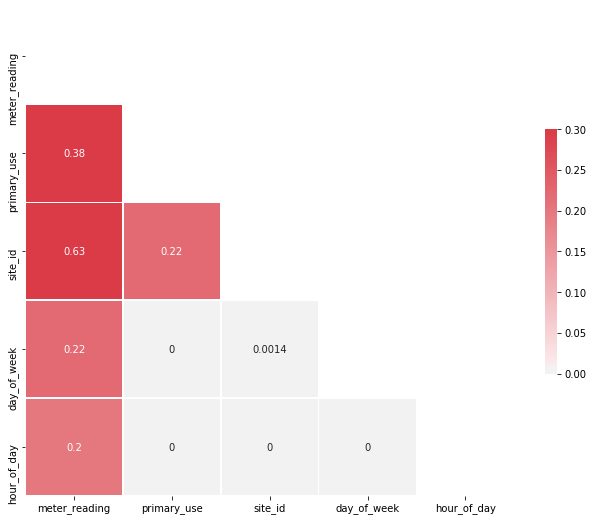

In [51]:
# Compute the correlation matrix
corr2 = pd.DataFrame(corrM, index=cols, columns=cols)
# Generate a mask for the upper triangle
mask = np.zeros_like(corr2, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr2, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot = True)

NOte: https://stackoverflow.com/questions/51859894/how-to-plot-a-cramer-s-v-heatmap-for-categorical-features



### Split data into training and test 

In [58]:
df_model_1_X = df.loc[:,~df.columns.isin(['meter_reading'])]
df_model_1_y = df.loc[:,df.columns.isin(['meter_reading'])]

In [59]:
# spliting the clean dataset into 70/30 for training/ test
X_train, X_test, y_train, y_test = train_test_split(df_model_1_X, df_model_1_y, test_size=0.3, random_state=1)

###  Model building

### Regression 1: The simpliest model  (using stat library and not sklearn)

Based on correlation above, we decided to first build a simple model with fewest key variables - square_feet, floor_count, primary_use, site_id, day_of_week, hour_of_day. 



In [66]:
X_train.columns

Index(['meter', 'site_id', 'primary_use', 'square_feet', 'year_built',
       'floor_count', 'time_index', 'day_of_week', 'hour_of_day', 'index',
       'avg', 'std', 'outlier', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'timestamp_utc', 'wind_direction', 'wind_speed', 'timezone',
       'country_code', 'location', 'dst', 'local_time'],
      dtype='object')

In [70]:
# Picking out x-variables we want to explore
X_train_a = X_train[['square_feet', 'floor_count', 'primary_use','site_id', 'day_of_week','hour_of_day']]
X_test_a = X_test[['square_feet', 'floor_count', 'primary_use','site_id', 'day_of_week', 'hour_of_day']]

# converting categorical data into dummy variables
X_train_a = pd.get_dummies (X_train_a, columns = ['primary_use','site_id','day_of_week', 'hour_of_day'])
X_test_a = pd.get_dummies (X_test_a, columns = ['primary_use','site_id','day_of_week', 'hour_of_day'])

# Dropping one categorical dummy variables
X_train_a= X_train_a.drop(columns = ['primary_use_Warehouse/storage', 'site_id_15', 'day_of_week_6', 'hour_of_day_23' ])
X_test_a= X_test_a.drop(columns = ['primary_use_Warehouse/storage', 'site_id_15', 'day_of_week_6', 'hour_of_day_23' ])

In [71]:
# Without Y-intercept
model = sm.OLS(y_train, X_train_a).fit()
predictions = model.predict(X_train_a) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:          meter_reading   R-squared (uncentered):                   0.643
Model:                            OLS   Adj. R-squared (uncentered):              0.643
Method:                 Least Squares   F-statistic:                          2.498e+05
Date:                Sun, 08 Dec 2019   Prob (F-statistic):                        0.00
Time:                        20:38:51   Log-Likelihood:                     -5.9060e+07
No. Observations:             8443617   AIC:                                  1.181e+08
Df Residuals:                 8443556   BIC:                                  1.181e+08
Df Model:                          61                                                  
Covariance Type:            nonrobust                                                  
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
square_feet                                   0.0015   9.57e-07   1530.127      0.000       0.001       0.001
floor_count                                  32.8750      0.037    881.663      0.000      32.802      32.948
primary_use_Education                       -47.7498      0.542    -88.096      0.000     -48.812     -46.687
primary_use_Entertainment/public assembly   -74.1123      0.575   -128.924      0.000     -75.239     -72.986
primary_use_Food sales and service          -24.7190      1.601    -15.443      0.000     -27.856     -21.582
primary_use_Healthcare                        8.4483      0.920      9.181      0.000       6.645      10.252
primary_use_Lodging/residential            -130.0384      0.577   -225.426      0.000    -131.169    -128.908
primary_use_Manufacturing/industrial        -43.4992      1.200    -36.250      0.000     -45.851     -41.147
primary_use_Office                          -74.2938      0.557   -133.286      0.000     -75.386     -73.201
primary_use_Other                           -82.7730      0.877    -94.336      0.000     -84.493     -81.053
primary_use_Parking                        -507.8268      0.938   -541.508      0.000    -509.665    -505.989
primary_use_Public services                 -79.5380      0.596   -133.473      0.000     -80.706     -78.370
primary_use_Religious worship                 3.0380      2.054      1.479      0.139      -0.987       7.063
primary_use_Retail                          -43.0273      1.165    -36.938      0.000     -45.310     -40.744
primary_use_Services                       -327.9847      1.261   -260.061      0.000    -330.457    -325.513
primary_use_Technology/science              -98.8492      1.574    -62.786      0.000    -101.935     -95.763
primary_use_Utility                          51.8896      1.819     28.524      0.000      48.324      55.455
site_id_0                                    94.4551      0.517    182.648      0.000      93.442      95.469
site_id_1                                  -102.5742      0.604   -169.908      0.000    -103.757    -101.391
site_id_2                                  -127.4396      0.456   -279.248      0.000    -128.334    -126.545
site_id_3                                   -89.2147      0.409   -218.319      0.000     -90.016     -88.414
site_id_4                                   -80.9352      0.509   -158.867      0.000     -81.934     -79.937
site_id_5                                   -68.0907      0.493   -138.006      0.000     -69.058     -67.124
site_id_6                                    -2.0720      0.653     -3.172      0.002      -3.352      -0.792
site_id_7     

In [73]:
# With Y-Intercept
X = sm.add_constant(X_train_a)
model = sm.OLS(y_train, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          meter_reading   R-squared:                       0.567
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                 1.815e+05
Date:                Sun, 08 Dec 2019   Prob (F-statistic):               0.00
Time:                        20:41:50   Log-Likelihood:            -5.9054e+07
No. Observations:             8443617   AIC:                         1.181e+08
Df Residuals:                 8443555   BIC:                         1.181e+08
Df Model:                          61                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
const                                      -132.3829      1.163   -113.805      0.000    -134.663    -130.103
square_feet                                   0.0015   9.56e-07   1533.513      0.000       0.001       0.001
floor_count                                  33.0325      0.037    885.955      0.000      32.959      33.106
primary_use_Education                        48.6923      1.006     48.415      0.000      46.721      50.663
primary_use_Entertainment/public assembly    21.8417      1.020     21.409      0.000      19.842      23.841
primary_use_Food sales and service           70.9753      1.807     39.279      0.000      67.434      74.517
primary_use_Healthcare                      103.6177      1.243     83.367      0.000     101.182     106.054
primary_use_Lodging/residential             -31.8937      1.037    -30.747      0.000     -33.927     -29.861
primary_use_Manufacturing/industrial         54.1188      1.474     36.709      0.000      51.229      57.008
primary_use_Office                           21.9049      1.012     21.639      0.000      19.921      23.889
primary_use_Other                            11.8719      1.208      9.824      0.000       9.503      14.240
primary_use_Parking                        -412.5952      1.256   -328.415      0.000    -415.058    -410.133
primary_use_Public services                  15.2253      1.024     14.873      0.000      13.219      17.232
primary_use_Religious worship               102.4084      2.230     45.917      0.000      98.037     106.780
primary_use_Retail                           53.3481      1.439     37.062      0.000      50.527      56.169
primary_use_Services                       -232.6942      1.513   -153.794      0.000    -235.660    -229.729
primary_use_Technology/science               -0.9855      1.793     -0.550      0.583      -4.499       2.528
primary_use_Utility                         153.7209      2.026     75.872      0.000     149.750     157.692
site_id_0                                   105.4436      0.526    200.581      0.000     104.413     106.474
site_id_1                                   -91.4652      0.611   -149.676      0.000     -92.663     -90.267
site_id_2                                  -114.5957      0.470   -243.937      0.000    -115.516    -113.675
site_id_3                                   -75.2523      0.426   -176.498      0.000     -76.088     -74.417
site_id_4                                   -69.4382      0.519   -133.796      0.000     -70.455     -68.421
site_id_5                                   -55.8068      0.505   -110.577      0.000     -56.796     -54.818
site_id_6                                     9.3450      0.660     14.152      0.000       8.051      10.639
sit

### Linear regression using sklearn using same features

In [74]:
# Training model using linear regression
regressor = LinearRegression()  
regressor.fit(X_train_a, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [75]:
# predicting y 
y_pred = regressor.predict(X_test_a)

In [76]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 121.15408698990548
Mean Squared Error: 69097.29709077573
Root Mean Squared Error: 262.8636473359824


In [77]:
r2_score(y_test, y_pred)

0.5699419753049282

In [78]:
print('Coefficients: \n', regressor.coef_)

Coefficients: 
 [[ 1.46677256e-03  3.30325403e+01  4.86922998e+01  2.18417023e+01
   7.09753100e+01  1.03617747e+02 -3.18937483e+01  5.41187918e+01
   2.19049068e+01  1.18719020e+01 -4.12595213e+02  1.52252732e+01
   1.02408424e+02  5.33480925e+01 -2.32694189e+02 -9.85490277e-01
   1.53720941e+02  1.05443589e+02 -9.14651926e+01 -1.14595719e+02
  -7.52523454e+01 -6.94382418e+01 -5.58067545e+01  9.34498162e+00
   1.57438695e+03  6.61405224e+01 -1.59819369e+01 -2.19158263e+01
   4.15310140e+01 -4.59737577e+01  6.22263163e+01  3.30204562e+01
   2.44489125e+01  2.78097602e+01  2.80246454e+01  2.68799879e+01
   2.25688584e+01  3.51883754e+00 -3.37724554e+00 -3.70561011e+00
  -7.54832331e+00 -8.08115902e+00 -7.17160631e+00 -2.90475200e+00
   4.64249233e+00  1.37400855e+01  2.26141277e+01  2.96053295e+01
   3.55034048e+01  3.89746275e+01  4.18675001e+01  4.26601152e+01
   4.33350835e+01  4.26573691e+01  3.90942490e+01  3.26552803e+01
   2.50815756e+01  2.02432694e+01  1.50163052e+01  1.0288685

In [81]:
# Printing RMSLE 
y_true = y_test['meter_reading'].values.tolist()
y_true = [0 if i <0 else i for i in y_true]
y_p = y_pred.ravel().tolist()
y_p = [0 if i <0 else i for i in y_p]
np.sqrt(metrics.mean_squared_log_error(y_true, y_p))

1.581147538987414

## Attempt 3:   Random Forest? This is WIP. 

In [82]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 1)

In [86]:
# Train the model on training data
rf.fit(X_train_a, y_train.meter_reading.ravel())

KeyboardInterrupt: 

In [ ]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)